In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from src.io import Spectrum, DataLoader

## Load data

In [6]:
# --- prep mean of spectra, covariances
dl = DataLoader()
dl.prep_data()         ## run only once

creating cache with iy=1
(1097, 30)
creating cache with iy=1
(935, 30)
creating cache with iy=1
(15000, 30)
creating cache with iy=1
(25, 30)
creating cache with iy=2
(25, 30)
creating cache with iy=3
(1097, 2600)
creating cache with iy=3
(970, 2600)
creating cache with iy=3
(15000, 2600)
creating cache with iy=3
(25, 2600)
creating cache with iy=4
(25, 2600)
data is prepared


In [7]:
ls cache/

abacus_bk_bao.npz         bk_mean_glam_nobao.npz   pk3_mean_glam_bao.npz
abacus_bk_nobao.npz       bk_mean_molino_bao.npz   pk3_mean_molino_bao.npz
abacus_pk_bao.npz         glam_bk_bao.npz          pk_cov_abacus_bao.npz
abacus_pk_nobao.npz       glam_bk_nobao.npz        pk_cov_glam_bao.npz
bk_cov_abacus_bao.npz     glam_pk_bao.npz          pk_mean_abacus_bao.npz
bk_cov_glam_bao.npz       glam_pk_nobao.npz        pk_mean_abacus_nobao.npz
bk_mean_abacus_bao.npz    molino_bk_bao.npz        pk_mean_glam_bao.npz
bk_mean_abacus_nobao.npz  molino_pk_bao.npz        pk_mean_glam_nobao.npz
bk_mean_glam_bao.npz      pk3_mean_abacus_bao.npz  pk_mean_molino_bao.npz


In [4]:
pk_glam_bao     = Spectrum('./cache/pk_mean_glam_bao.npz')
pk_glam_nobao   = Spectrum('./cache/pk_mean_glam_nobao.npz')
pk_abacus_bao   = Spectrum('./cache/pk_mean_abacus_bao.npz')
pk_abacus_nobao = Spectrum('./cache/pk_mean_abacus_nobao.npz')

bk_glam_bao     = Spectrum('./cache/bk_mean_glam_bao.npz')
bk_glam_nobao   = Spectrum('./cache/bk_mean_glam_nobao.npz')
bk_abacus_bao   = Spectrum('./cache/bk_mean_abacus_bao.npz')
bk_abacus_nobao = Spectrum('./cache/bk_mean_abacus_nobao.npz')

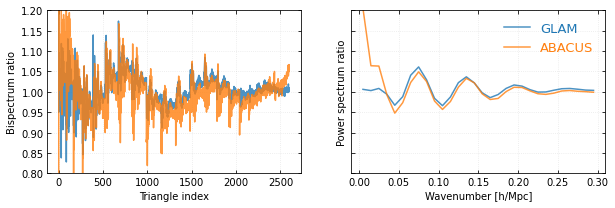

In [9]:
tix =  np.arange(bk_glam_bao.x.shape[0])
src.plots.plot_spectra([(tix,   bk_glam_bao.y/bk_glam_nobao.y),
                        (tix,   bk_abacus_bao.y/bk_abacus_nobao.y)], 
                       [(pk_glam_bao.x, pk_glam_bao.y/pk_glam_nobao.y),
                        (pk_glam_bao.x, pk_abacus_bao.y/pk_abacus_nobao.y)],
                       ['GLAM', 'ABACUS'])

In [51]:
cov_glam = Spectrum('./cache/pk_cov_glam_bao.npz')

In [48]:
bk_glam_bao.x.shape

(2600, 3)

In [54]:
np.diff(bk_glam_bao.x[:, 0])[-10:]

array([0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.01])

(0.8, 1.2)

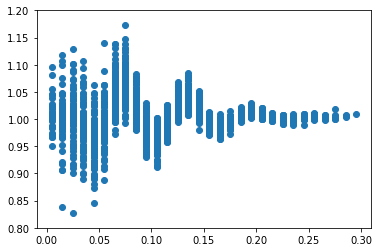

In [8]:
plt.scatter(bk_glam_bao.x[:, 0], bk_glam_bao.y/bk_glam_nobao.y)
plt.ylim(0.8, 1.2)

In [42]:
pk_glam = np.load('cache/glam_pk_bao.npz')
pk_molino = np.load('cache/molino_pk_bao.npz')

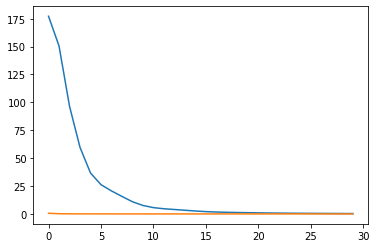

In [47]:
plt.plot(np.diagonal(np.cov(pk_glam['y'], rowvar=False))/(np.var(pk_glam['y'], axis=0)/pk_glam['y'].mean(axis=0)**2))
plt.plot(np.diagonal(np.cov(pk_molino['y'], rowvar=False))/(np.var(pk_molino['y'], axis=0)/pk_molino['y'].mean(axis=0)**2))
# plt.yscale('log')

In [25]:
pk_glam['y'].shape

(1097, 30)

Text(0, 0.5, 'P(k)')

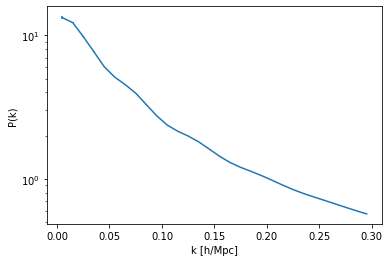

In [41]:
plt.errorbar(pk_glam_bao.x, pk_glam_bao.y, yerr=np.diagonal(cov_glam.y)**0.5)
# plt.errorbar(pk_glam_bao.x, pk_glam_bao.y, yerr=np.std(pk_glam['y'], axis=0)/np.sqrt(1097))
# plt.loglog()
plt.yscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel('P(k)')

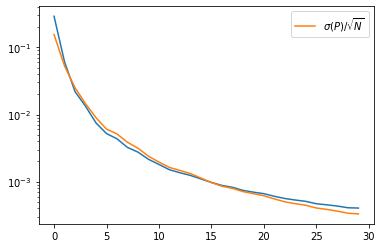

In [35]:
plt.plot(np.diagonal(cov_glam.y)**0.5, label='From ')
plt.plot(np.std(pk_glam['y'], axis=0)/np.sqrt(1097), label=r'$\sigma(P)/\sqrt{N}$')

plt.yscale('log')
plt.legend()

## Test MCMC

In [14]:
from glob import glob

In [57]:
def read_sigmas(chains):
    
    kmax = []
    sigma = []
    for ch in np.sort(chains):
        ch_ = np.load(ch)
        kmax.append(ch_['klim'][1])
        sigma.append(ch_['chain'][5000:, :, 0].std())
        
    print(ch_['klim'][0])
    return kmax, sigma

In [59]:
kmax1, sigma1 = read_sigmas(glob('mcmc_jan30/pk_abacus_abacus_*.npz'))
kmax2, sigma2 = read_sigmas(glob('mcmc_jan30//pk_glam_glam_*.npz'))
# kmax3, sigma3 = read_sigmas(glob('mcmc_jan30/bk_abacus_abacus_*.npz'))
# kmax4, sigma4 = read_sigmas(glob('mcmc_jan30/bk_glam_glam_*.npz'))

0.015
0.015


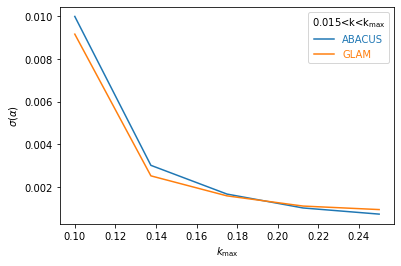

In [60]:
plt.plot(kmax1, sigma1, label='ABACUS')
plt.plot(kmax3, sigma3, color='C0', ls='--')

plt.plot(kmax2, sigma2, label='GLAM')
plt.plot(kmax4, sigma4, color='C1', ls='--')

plt.xlabel(r'$k_{\rm max}$')
plt.ylabel(r'$\sigma (\alpha)$')
lgn = plt.legend(title=r'0.015<k<k$_{\rm max}$')
for i, txt in enumerate(lgn.get_texts()):
    txt.set_color('C%d'%i)
# plt.yscale('log')    
# plt.xlim(0.09, 0.25)

In [63]:
d_ = np.load('mcmc_jan30/pk_abacus_abacus_0.015_0.250.npz')
# d = np.load('mcmcs/mcmc_is_bk_kmax_0.12_quad_v1.1.npz')

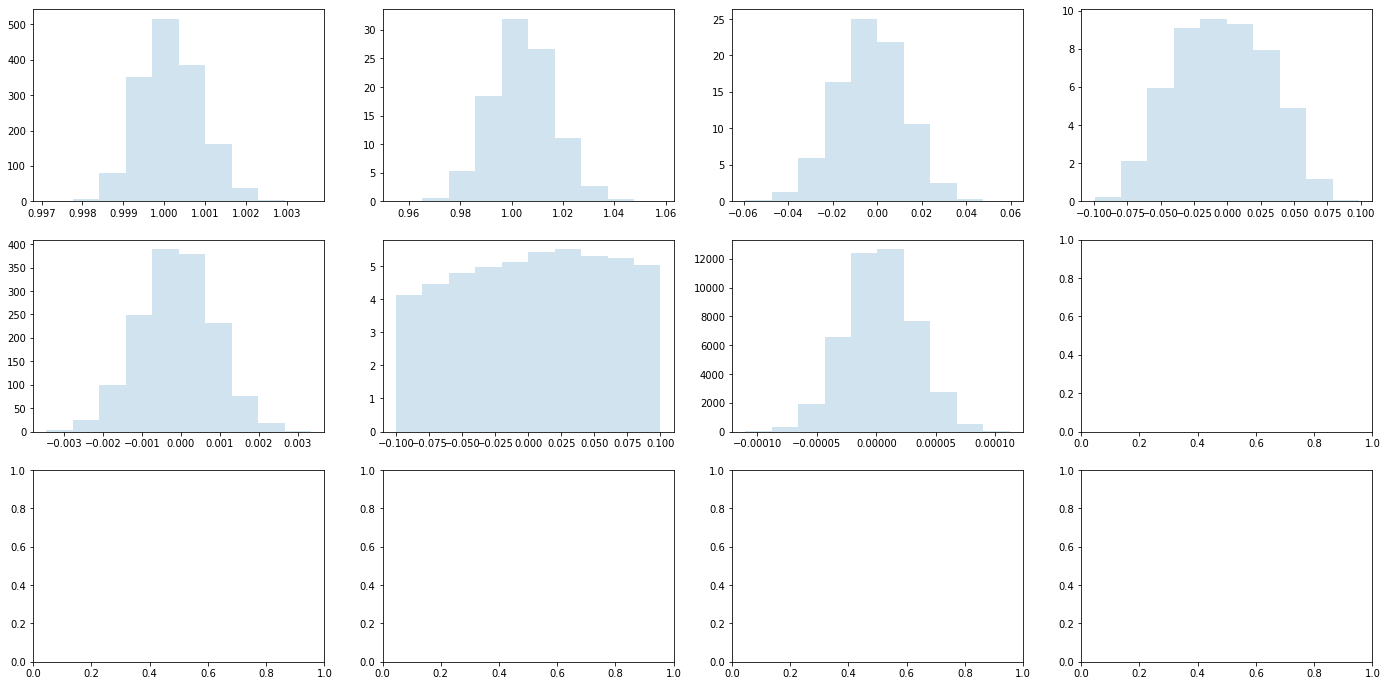

In [64]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(24, 12))
ax = ax.flatten()

for i in range(7):
    # ax[i].hist(d['chain'][5000:, :, i].flatten(), alpha=0.2, density=True)
    ax[i].hist(d_['chain'][5000:, :, i].flatten(), alpha=0.2, density=True)
    

In [13]:
d_['chain'][5000:, :, 0].std()

0.009283421813139995

In [14]:
d['chain'][5000:, :, 0].std()

0.012622513944637873

In [4]:
stat = 'bk'
mock = 'glam'
temp = 'glam'
y = Spectrum(f'cache/{stat}_mean_{mock}_bao.npz')
ys = Spectrum(f'cache/{stat}_mean_{temp}_nobao.npz')
cov = Spectrum(f'cache/{stat}_cov_{mock}_bao.npz')

In [5]:
is_g = (y.x > 0.015) & (y.x < 0.13) 
is_g = is_g.sum(axis=1) == 3

x_g = y.x[is_g]
r_g = (y.y/ys.y)[is_g]
c_g = cov.y[is_g,:,][:, is_g]
ic_g = np.linalg.inv(c_g)

In [9]:
from src.models import BiSpectrum

In [10]:
r_int = BiSpectrum(y.x, y.y/ys.y)

In [29]:
def loglike(p):
    res = r_g - r_int(x_g, p)
    is_ok = ~np.isnan(res)    
    #if is_ok.sum() ==0:
    #    return -np.inf
    #else:            
    return  -0.5*res[is_ok].dot(ic_g[is_ok, :][:, is_ok].dot(res[is_ok]))

def logprior(p):
    lp = 0.
    lp += 0. if  0.9 < p[0] < 1.1 else -np.inf
    lp += 0. if  0.8 < p[1] < 1.2 else -np.inf    
    for p_i in p[2:]:
        lp += 0. if  -1 < p_i < 1. else -np.inf
    return lp

def logpost(p):
    return loglike(p) + logprior(p)

def nlogpost(p):
    return -1.*logpost(p)

In [30]:
guess = np.array([1.001, 1.001, 1.1e-5, 1.2e-5, 1.3e-5, 1.1e-5, 1.2e-5, 1.3e-5, 1.0e-5, 0.9e-5, 1.1e-5])
start = (guess + guess*0.02*np.random.randn(50, 11))

In [31]:
for s in start:
    print(logpost(s))

-0.019408861842226496
-0.007620845077150634
-0.007888390203940148
-0.008862727394702438
-0.0024373891472734568
-0.01406453427391325
-0.017468073171336744
-0.0901179160143377
-0.0023148334411223475
-0.020863976518058932
-0.034029590589402275
-0.008627994620870622
-0.002027414006793732
-0.007155820757474676
-0.005916715661599145
-0.0031888498545395083
-0.026194485193954536
-0.009948746348104914
-0.004950925198240695
-0.0030730159466689374
-0.002608491247113996
-0.013832275991846894
-0.01014591490436914
-0.017581117210251573
-0.018327415319419213
-0.00800648592484167
-0.009829408943324135
-0.03152695528977704
-0.06331713761471565
-0.013110156783927913
-0.01415095152754359
-0.01224262929471479
-0.010791320474832326
-0.054848706455694604
-0.021607669673610247
-0.013293553227040206
-0.003061372293617159
-0.0006656195760880825
-0.001774707942634408
-0.018009694934513945
-0.009454128082254858
-0.010761348131810008
-0.10845174738823338
-0.030046678096103747
-0.0014945713867181255
-0.00276594295

In [ ]:
#     vr = 8
#     p = 1.5
#     ax[2].plot(bk_abacus.var(axis=0)/p3_abacus*vr**p, label='ABACUS', alpha=0.8)
#     ax[2].plot(bk_glam.var(axis=0)/p3_glam,           label='GLAM')
#     ax[2].plot(bk_molino.var(axis=0)/p3_molino,       label='MOLINO')
#     ax[3].plot(k, pk_abacus.var(axis=0)/pk_abacus.mean(axis=0)**2*vr**p, label='ABACUS')
#     ax[3].plot(k, pk_glam.var(axis=0)/pk_glam.mean(axis=0)**2,           label='GLAM')
#     ax[3].plot(k, pk_molino.var(axis=0)/pk_molino.mean(axis=0)**2,       label='MOLINO')
#     ax[2].set(xlabel='Triangle index', yscale='log', 
#               ylabel='Normalized bispectrum dispersion')#, ylabel=r'$\frac{\sigma^{2}_{B}}{P^{3}V^{1.5}}$')
#     ax[3].legend(bbox_to_anchor=(-1, 2.1, 1.5, 0.15), 
#                  mode='expand', ncol=3, frameon=False, fontsize=13)    
#     # fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
#     # ax[0].set(ylabel=r'$\chi^{2}(\alpha)$', xlabel=r'$\alpha$', title='Scoccimaro template')
#     # ax[1].set(xlabel=r'$\alpha$', title='GLAM template')
#     # # different curves for different k-max values

#     # fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
    # ax[0].set(xlabel='Triangle index', title='GLAM', ylabel='Bispectrum ratio')
    # ax[1].set(xlabel=r'kmax', title='GLAM', ylabel=r'$\sigma(\alpha)$')      

In [11]:
pk_glam_bao.x, pk_glam_bao.y

(array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
        0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
        0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
        0.275, 0.285, 0.295]),
 array([13.30533495, 12.26090917,  9.8172015 ,  7.718056  ,  6.04934489,
         5.11676342,  4.53520081,  3.95469598,  3.29829311,  2.75108726,
         2.37053697,  2.14782723,  1.98742684,  1.81072653,  1.61351515,
         1.43488749,  1.29848154,  1.20190007,  1.12622522,  1.052373  ,
         0.97680565,  0.90427197,  0.84115018,  0.78982083,  0.74668514,
         0.70710681,  0.66898349,  0.63290016,  0.59951996,  0.56984191]))

array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285, 0.295])

In [ ]:
k, pk_glam = dl.load('glam_pk_bao', 1)
__, pk_glam_nobao = dl.load('glam_pk_nobao', 1)
__, pk_molino = dl.load('molino_pk', 1)
__, pk_abacus = dl.load('abacus_pk', 1)
__, pk_abacus_nobao = dl.load('abacus_pk_nobao', 2)

k3, bk_glam = dl.load('glam_bk_bao', 3)
__, bk_glam_nobao = dl.load('glam_bk_nobao', 3)
__, bk_molino = dl.load('molino_bk', 3)
__, bk_abacus = dl.load('abacus_bk', 3)
__, bk_abacus_nobao = dl.load('abacus_bk_nobao', 4)

p3_abacus = get_p3(k3, pk_abacus.mean(axis=0))
p3_molino = get_p3(k3, pk_molino.mean(axis=0))
p3_glam   = get_p3(k3, pk_glam.mean(axis=0))



loading cache...
(1097, 30)
loading cache...
(935, 30)
loading cache...
(15000, 30)
loading cache...
(25, 30)
loading cache...
(25, 30)
loading cache...
(1097, 2600)
loading cache...
(970, 2600)
loading cache...
(15000, 2600)
loading cache...
(25, 2600)
loading cache...
(25, 2600)


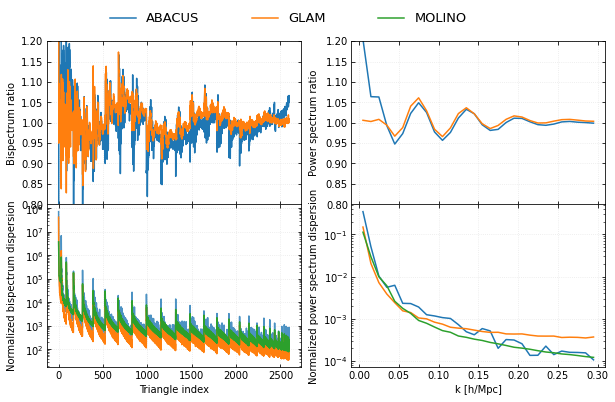

In [5]:
plot_spectra(dl)

loading cache...
(1097, 30)
loading cache...
(935, 30)
loading cache...
(15000, 30)
loading cache...
(25, 30)
loading cache...
(25, 30)
loading cache...
(1097, 2600)
loading cache...
(970, 2600)
loading cache...
(15000, 2600)
loading cache...
(25, 2600)
loading cache...
(25, 2600)


In [7]:
# C_P ~ var(P)/(P^{2}V^p)  # p = 1.5
# C_B ~ var(B)/(P^{3}V^p)

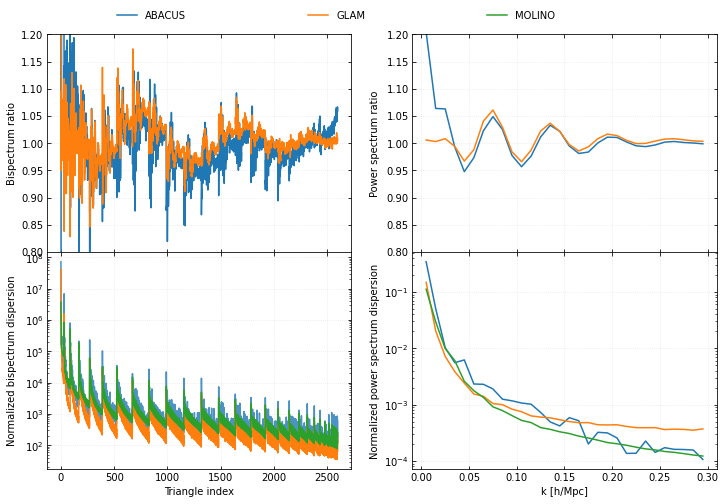

In [8]:
rcov_p = get_cov(pk_molino)
rcov_b = get_cov(bk_molino)

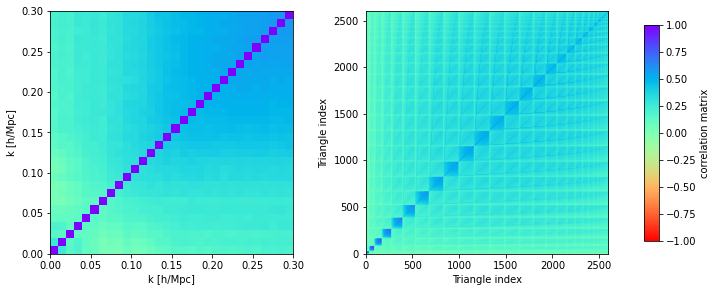

In [10]:
plot_rcov(rcov_p, rcov_b)

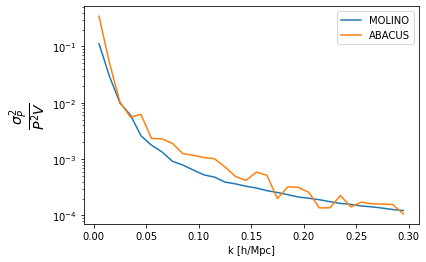

In [2]:
%matplotlib inline

In [3]:
import helpers as hp

In [5]:
bk_a = hp.read_abacus_bk()
bk_g = hp.read_glam_bk()
bk_gs = hp.read_glam_bk_nobao()

In [21]:
files = glob('/mnt/data1/Abacus_All/all_pk_LRGz0_8000.txtall_bk_LRGz0_*.txt')
# d = np.loadtxt('/mnt/data1/Abacus_All/all_bispectrum/all_bk_LRGz0_8000.txt').T
# d.shape
print(len(files))
y_1 = []
for file_i in files:
    d_ = np.loadtxt(file_i).T
    y_1.append(d_[4, :])
bk_as = np.mean(y_1, axis=0)

25


In [27]:
bk_g['pk'].shape

(1097, 2600)

In [15]:
bk_a['pk'].shape

(25, 2600, 3)

Text(0, 0.5, 'Bispectrum Ratio')

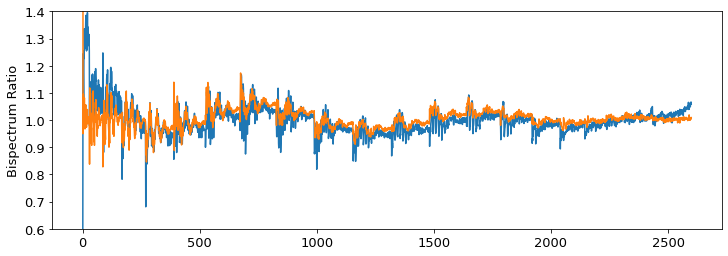

In [30]:
plt.figure(figsize=(12, 4))
plt.plot(bk_a['pk'][:, :, 0].mean(axis=0)/bk_as)
plt.plot(bk_g['pk'].mean(axis=0)/bk_gs['pk'].mean(axis=0))
plt.ylim(0.6, 1.4)
plt.ylabel('Bispectrum Ratio')

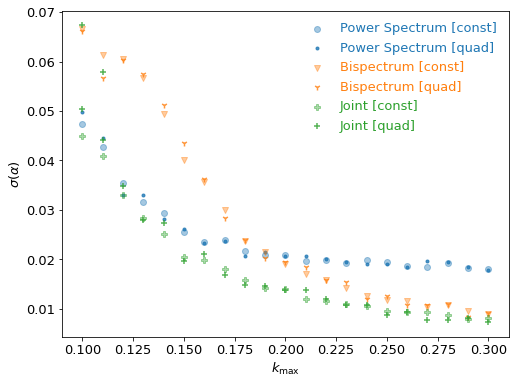

In [3]:
plot_sigma_kmax()

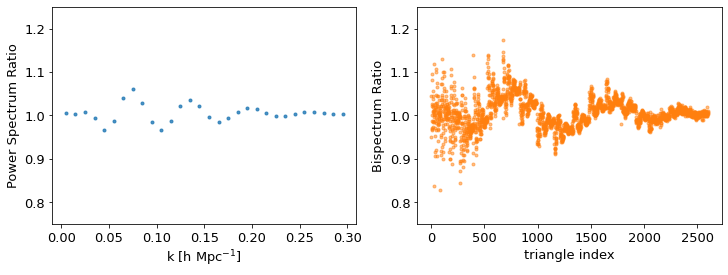

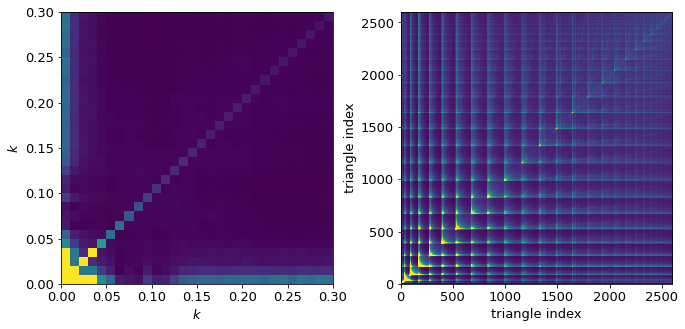

In [4]:
plot_spectra_glam()

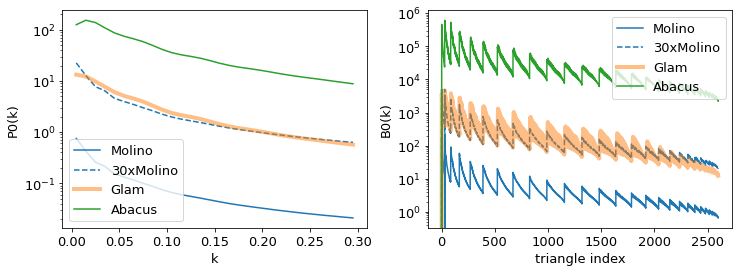

In [5]:
plot_spectra()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


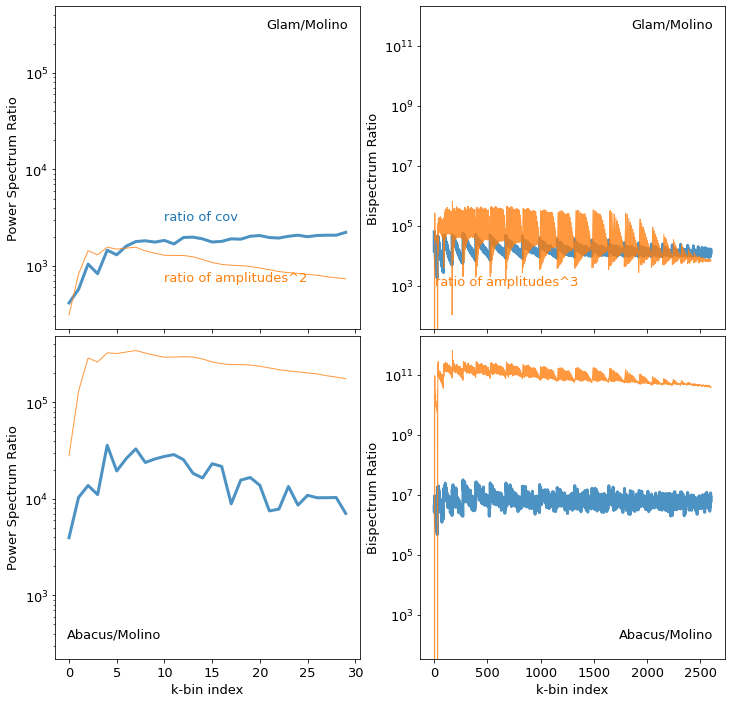

In [13]:
plot_ratios()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


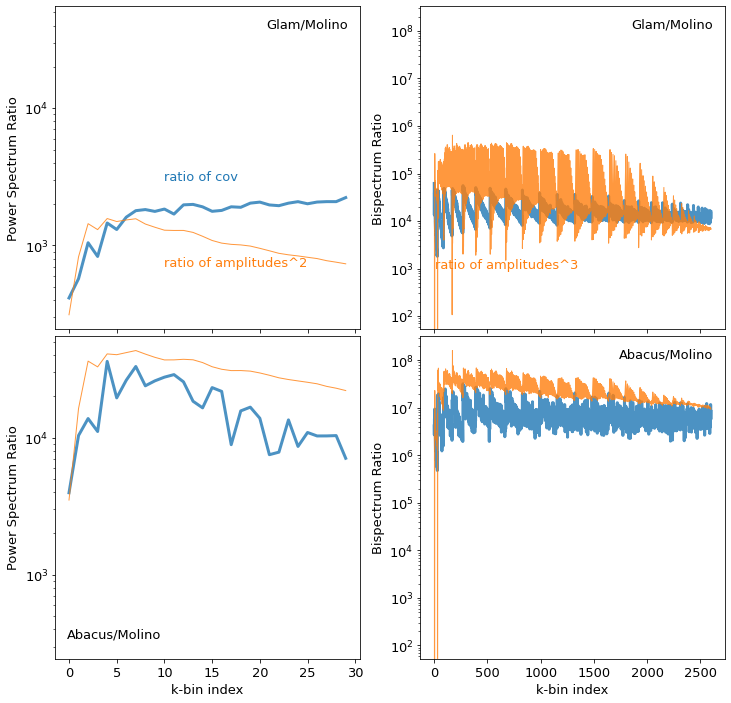

In [7]:
plot_ratios()

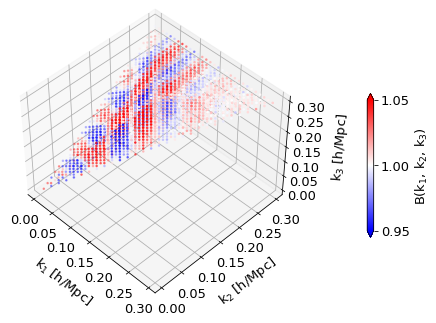

In [7]:
plot_glambk()

In [ ]:
# compare the ratio of covariance (diagonal) to the ratio of amplitudes
# Abacus variance is more sensitive to # of realizations rather than the amplitude

In [1]:
from scipy.stats import binned_statistic

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
d1 = np.load('mcmcs/mcmc_is_pk_kmax_0.25_quad_v1.1.npz')
d2 = np.load('mcmcs/mcmc_is_joint_kmax_0.25_quad_v1.1.npz')
d3 = np.load('mcmcs/mcmc_is_joint_kmax_0.25_quadnobao_v1.2.npz')

[Text(0.5, 0, '$\\alpha$'), Text(0, 0.5, '$\\chi^{2}_{\\rm min}$')]

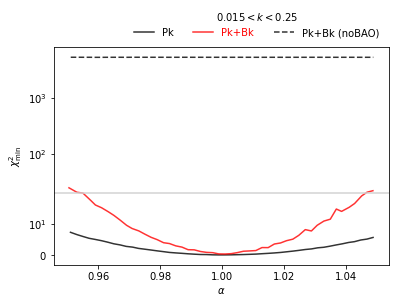

In [35]:

#        ylim=(-0.5, 5.), xlim=(0.94, 1.06))
fig, ax = plt.subplots()

alpha_edge = np.linspace(0.95, 1.05, num=51)

c = ['k', 'red', 'k']
ls = ['-', '-', '--']
 
for i, (di, ni) in enumerate(zip([d1, d2, d3],
                                 ['Pk', 'Pk+Bk', 'Pk+Bk (noBAO)'])):
    x = di['chain'][:, :, 0].flatten()
    y = -2.*di['log_prob'].flatten()
    
    ym = binned_statistic(x, y, statistic=np.min, bins=alpha_edge)[0]
    xm = binned_statistic(x, x, statistic=np.mean, bins=alpha_edge)[0]
    
    ax.plot(xm, ym, label=ni, ls=ls[i], color=c[i], alpha=0.8)#, marker='.')

ax.set_yscale('symlog', linthresh=20.)    
leg = ax.legend(frameon=False, title=r'$0.015<k<0.25$', 
                bbox_to_anchor=(0.0, 1.01, 1.0, 0.2), ncol=3)
for i, text in enumerate(leg.get_texts()):text.set_color(c[i])
ax.axhline(20., color='lightgrey')
ax.set(xlabel=r'$\alpha$', ylabel=r'$\chi^{2}_{\rm min}$')

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
from glob import glob

25

(0.8, 1.2)

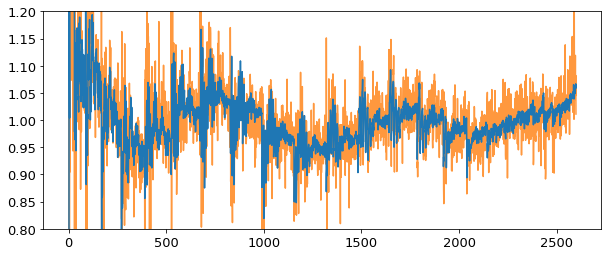

In [29]:
plt.figure(figsize=(10, 4))
plt.plot(np.mean(y_1, axis=0)/np.mean(y_2, axis=0))
plt.plot(y_1[2]/y_2[2], alpha=0.8, zorder=-10)
plt.ylim(0.8, 1.2)

(0.8, 1.2)

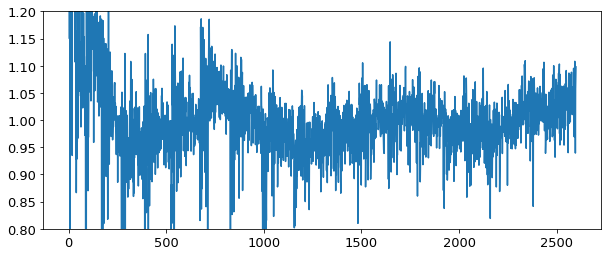

In [19]:
plt.figure(figsize=(10, 4))
plt.plot(d[3, :]/d[4, :])
plt.ylim(0.8, 1.2)

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(d[3, :]/d[4, :]) # 
plt.ylim(0.8, 1.2)